# Figure 4a

Correlations stuff

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
import matplotlib.pyplot as plt

sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
from parameters import params
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Parameters

In [3]:
quench_time = 300*ureg.s
evolution_time = 60*ureg.s
total_time = 500*ureg.s
sim_path = '/media/eru/ina/stuckgs/data/simstair'
data_path = '/media/eru/ina/stuckgs/data/'

## Correlations

Here I will generalte all the correlation timeseries for all realizations for all particles.

In [4]:
data = pd.read_csv(os.path.join(sim_path,'rparallels.csv'), index_col=[0,1])
data

0         1         2         3         4         5  \
realization frame                                                              
1           0      1.50000  1.500000 -1.500000  1.500000 -1.500000  1.500000   
            5      1.18864  1.456700 -1.441500  1.380400 -1.400101  1.274902   
            10     1.48959  1.097000 -1.345200  1.373199 -1.243702  0.905502   
            15     1.04373  1.327500 -1.410099  1.400101 -1.462303  0.659302   
            20     0.62998  1.200200 -1.240099  1.204901 -1.206501  0.323803   
...                    ...       ...       ...       ...       ...       ...   
10          11975  0.29411  1.024800  1.037500 -1.103399 -0.619602  1.132000   
            11980  0.34811  1.068700  1.018301 -0.983200 -0.240002  1.063503   
            11985  0.52392  1.096000  1.120100 -1.125601 -0.561001  1.199802   
            11990  0.29285  1.017301  0.968800 -0.967600 -0.638603  1.180202   
            11995  0.24833  0.940500  1.059000 -0.959801 -0.548801  1.115700   

                          6         7         8         9  ...      1790  \
realization frame                                          ...             
1           0     -1.500000  1.500000 -1.500000  1.500000  ...  1.500000   
            5     -1.053299  0.909100 -1.128304  1.485199  ...  1.403000   
            10    -1.067101  1.053902 -1.321602  1.483902  ...  0.879990   
            15    -0.892899  0.526901 -1.453903  1.294701  ...  1.239990   
            20    -0.924999  0.525200 -1.330101  1.246002  ...  1.442001   
...                     ...       ...       ...       ...  ...       ...   
10          11975 -1.060699  0.086300  1.159103 -1.275299  ...  1.513992   
            11980 -1.170300  0.185200  1.131699 -1.313004  ...  1.511002   
            11985 -1.193897 -0.013798  1.042702 -1.238800  ...  1.502991   
            11990 -1.102299 -0.209499  1.162399 -1.363403  ...  1.513000   
            11995 -1.129299  0.021900  1.126396 -1.360901  ...  1.509995   

                       1791      1792      1793      1794      1795      1796  \
realization frame                                                               
1           0      1.500000  1.500000  1.500000  1.500000 -1.500000 -1.500000   
            5      1.274002  1.462997  1.390991  1.388992 -1.100998 -1.499008   
            10     1.252991  1.244995  1.039993  1.429993 -0.764008 -1.355011   
            15     1.117996  1.261993  1.354996  1.500000 -0.454010 -1.325012   
            20     0.945999  1.138992  1.421997  1.186996 -0.130005 -1.501999   
...                     ...       ...       ...       ...       ...       ...   
10          11975  1.524994 -1.518005  1.528000  1.500992 -1.503006  1.500992   
            11980  1.537003 -1.521011  1.549988  1.504990 -1.503006  1.506989   
            11985  1.549988 -1.526001  1.539993  1.507996 -1.503006  1.498001   
            11990  1.534988 -1.539001  1.534988  1.503998 -1.507004  1.514999   
            11995  1.539001 -1.525009  1.542999  1.477997 -1.510010  1.518997   

                       1797      1798      1799  
realization frame                                
1           0     -1.500000 -1.500000 -1.500000  
            5     -1.454010 -1.055008 -1.362000  
            10    -0.885010 -1.375000 -1.339005  
            15    -0.690002 -1.427002 -1.453003  
            20    -0.477005 -1.354004 -1.479004  
...                     ...       ...       ...  
10          11975  1.522995  1.504990  1.534988  
            11980  1.526001  1.524994  1.537003  
            11985  1.522995  1.513000  1.534988  
            11990  1.543991  1.501999  1.539993  
            11995  1.522995  1.502991  1.533997  

[24000 rows x 1800 columns]

In [5]:
realizations = data.index.get_level_values('realization').unique().to_list()

h = 30
intervals = [
 (30, 60),
 (90, 120),
 (150, 180),
 (210, 240),
 (270, 300),
 (330, 360),
 (390, 420),
 (450, 480),
 (510, 540),
 (570, 600),
]


In [6]:
def correlate_realization(sim_path,data,realization,interval,s,e):
    """
        This calculates the correlations functions for all particles in a given time interval.
        Saves all the data.
    """
    
    # Selecting the appropiate realization and its frames
    cdata = data.loc[idx[realization,:]]
    sframes = cdata.index.get_level_values('frame').unique().to_list()
    particle_ids = data.columns
    
    # Selecting all the particles time-selies
    cts = cdata[particle_ids].to_numpy().transpose()
    subselframes, correlations = aux.correlate_bframes(params,cts,sframes,stime=s,etime=e)

    # Making the appropiate df
    corr_df = pd.DataFrame(np.array(correlations).transpose()) # Putting each time-series as columns
    numbered = list(corr_df.columns)
    corr_df['frame'] = subselframes
    corr_df['realization'] = [realization] * len(subselframes)
    corr_df[['realization','frame'] + numbered]

    if realization == 1:
        corr_df.to_csv(os.path.join(sim_path,f'corr{interval}.csv'), index=False)
    else:
        corr_df.to_csv(os.path.join(sim_path,f'corr{interval}.csv'), index=False, header=False, mode='a')
    


In [7]:
corr_path = '/media/eru/ina/stuckgs/data/figs/correlations'
for i,(s,e) in enumerate(intervals):
    print(f'Interval ({s},{e})')
    for realization in realizations:
        correlate_realization(corr_path,data,realization,i,s,e)

Interval (30,60)
Interval (90,120)
Interval (150,180)
Interval (210,240)
Interval (270,300)
Interval (330,360)
Interval (390,420)
Interval (450,480)
Interval (510,540)
Interval (570,600)


## Averages

Now it is time to load them one by one and take the averages, std, normalize and stuff.

In [8]:
for interval in range(len(intervals)):
    avs = []
    for realization in realizations:
        corr_int = pd.read_csv(os.path.join(corr_path,f'corr{interval}.csv'),index_col=['realization','frame'])
        frames = corr_int.index.get_level_values('frame').unique().to_numpy()
        dt = (frames - frames[0]) / params['framespersec'].magnitude
        
        particle_average = corr_int.loc[idx[realization,:]].mean(axis=1)
        particle_average = particle_average / particle_average.max()
        avs.append(particle_average.to_list())

    df = pd.DataFrame( np.array(avs).mean(axis=0), columns=['av'])
    df['dt'] = dt
    df['interval'] = [interval] * len(frames)

    if interval == 0:
        df.to_csv(os.path.join(corr_path,'global.csv'), index=False)
    else:
        df.to_csv(os.path.join(corr_path,'global.csv'), index=False,mode = 'a', header=False)



## Visualization

In [9]:
corravs = pd.read_csv(os.path.join(corr_path,'global.csv'), index_col=['interval','dt'])
nintervals = corravs.index.get_level_values('interval').unique().to_list()

In [10]:
rate = params['max_field']/quench_time
fields = [1,2,3,4,5,6,7,8,9,10]
fields


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

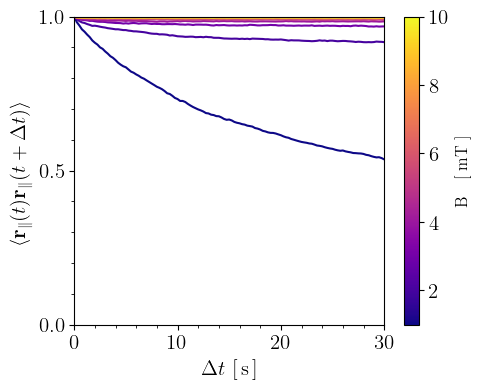

In [13]:
fig, ax = plt.subplots(figsize = (5,4))
cmap = plt.get_cmap('plasma')

for interval, (i,B) in zip(nintervals, enumerate(fields)):
    color =  cmap(i / (len(fields) - 1))
    avi = corravs.loc[idx[interval,'av']]
    ax.plot(avi.index.to_list(),avi.to_list(), color=color)

ax.set_xlim(0,h)
ax.set_ylim(0,1)
ax.set_xlabel("$\\Delta t$ [\\,s\\,]", fontsize=15)
ax.set_ylabel("$\\langle \\mathbf{r}_\\parallel(t) \\mathbf{r}_\\parallel(t+\\Delta t)\\rangle$",fontsize=15)

ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.xaxis.set_minor_formatter(plt.NullFormatter())


ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

ax.tick_params(axis='both', which='major', labelsize=15)
ax.minorticks_on()

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=10))
sm.set_array([])
cbar = plt.colorbar(sm,ax=ax)
cbar.set_label(label='B \\,\\, [ mT ]',size='large')
cbar.ax.tick_params(labelsize=15)

fig.savefig(os.path.join(data_path,'figs/fig4a.png'),dpi=300,bbox_inches='tight')
fig.savefig(os.path.join(data_path,'figs/fig4a.pdf'))

plt.show()

## Energy as a function of time

In [ ]:
def calulate_energy_at_frame_rl(params,data_path,size,frame,realization):
    
    params['size'] = size
    
    trj = pd.read_csv(os.path.join(data_path,str(size),'trj',f'trj{realization}.csv'), index_col=[0,1])
    #last_frame = trj.index.get_level_values('frame').unique()[-1]
    particles = aux.get_coordinates_at_frame(trj,frame)
    dis_energy = aux.calculate_energy(params,particles)
    return dis_energy